In [68]:
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# load data
nike_stock = pd.read_csv(r'data/nike_stock.csv')

In [3]:
nike_stock.head(10)

,Date,Close
0,9/18/1981 16:00:00,0.15
1,9/21/1981 16:00:00,0.16
2,9/22/1981 16:00:00,0.15
3,9/23/1981 16:00:00,0.15
4,9/24/1981 16:00:00,0.15
5,9/25/1981 16:00:00,0.15
6,9/28/1981 16:00:00,0.14
7,9/29/1981 16:00:00,0.15
8,9/30/1981 16:00:00,0.15
9,10/1/1981 16:00:00,0.15


In [4]:
# cleaning
nike_stock['Date'] = nike_stock['Date'].astype('datetime64[ns]')
nike_stock['Date'] = nike_stock['Date'].dt.date.astype('datetime64[ns]')
nike_stock.columns = ['Date', 'Price']

In [5]:
# imputations
dates = pd.DataFrame((pd.date_range(start=nike_stock['Date'].min(), end=nike_stock['Date'].max())), columns=['Date'])
nike_stock = nike_stock.merge(dates, on='Date', how='right')
nike_stock['Price'] = nike_stock['Price'].interpolate()

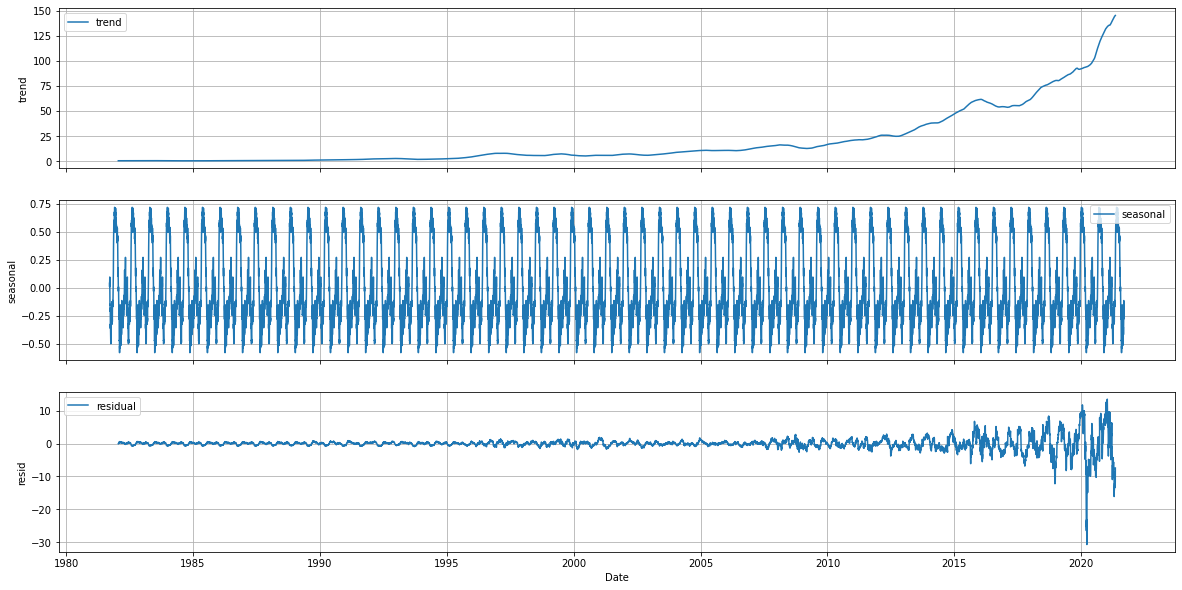

In [10]:
# trend, seasonal, residual
result = sm.tsa.seasonal_decompose(nike_stock.set_index('Date'), period=253)
trend = result.trend
seasonal = result.seasonal
residual = result.resid
'''
The NYSE and NASDAQ average about 253 trading days a year. 
This is from 365.25 (days on average per year) * 5/7 (proportion work days per week) - 6 (weekday holidays) - 3*5/7 (fixed date holidays) = 252.75 ≈ 253. 
The holidays where the stock exchange is closed are 
New Year's Day, 
Martin Luther King, Jr. Day, 
Presidents' Day, 
Good Friday, 
Memorial Day, 
Independence Day, 
Labor Day, 
Thanksgiving Day, 
and Christmas Day; 
there are also some holidays where trading is permitted, including Columbus Day, Veterans Day, and New Year's Eve.
'''
# plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(20, 10))
sns.lineplot(data=trend, ax=ax1, label='trend')
sns.lineplot(data=seasonal, ax=ax2, label='seasonal')
sns.lineplot(data=residual, ax=ax3, label='residual')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show();

In [96]:
# train val test split
def make_train_val_test(df, test_size=0.2, n_split=5, shuffle=False):
    '''get train, val, and test data.'''
    
    df = df.reset_index(drop=True)
    if test_size < 1:
        test_size = int(len(df) * test_size)
        #print(test_size)
    
    # test set
    test = df.iloc[-test_size:, :]
    
    # train/val set
    train = df.loc[~df.index.isin(test.index)]
    bags = []
    
    for b in range(n_split):
        bags.append(train.iloc[int(b/5 * len(train)):int((b + 1)/5 * len(train)), :])
    if shuffle:
        random.shuffle(bags)
    
    train = pd.concat(bags[:n_split-1], axis=0)
    val = bags[n_split-1]
    
    return train, val, test

train, val, test = make_train_val_test(nike_stock)

In [99]:
arma = ARMA(train.set_index('Date'), order=(10, 0)).fit()
print(f'AIC: {arma.aic}')

c:\users\15734\venv\dev_env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\15734\venv\dev_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency

AIC: -21727.927101273595


In [102]:
# predict validation
val_pred = arma.predict(start=val.index[0], end=val.index[-1])